In [97]:
import os
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import xarray as xr
import re

In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
data_dir = Path('../Data')
original_seq_path = data_dir / '/Users/thomasbush/Documents/ML/gfp_tryout/data/P42212.fasta.txt'
data_set_path = data_dir / '/Users/thomasbush/Documents/ML/gfp_tryout/data/amino_acid_genotypes_to_brightness.tsv'

In [100]:
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Step 2: Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 3: Import the function from utils.py
from scripts.utils import mutate_sequence, load_seq_, load_dataset

In [101]:
dataset = load_dataset(data_set_path, sep='\t')
seq, mapping = load_seq_(original_seq_path)
dataset['seq_mutated'] = dataset['aaMutations'].apply(
    lambda muts: mutate_sequence(muts, seq=seq, mapping_db_seq=mapping)
)

In [102]:
dataset

,aaMutations,uniqueBarcodes,medianBrightness,std,seq_mutated
0,NaN,3645,3.719212,0.106992,None
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,SA108G,2,3.708478,0.020613,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
...,...,...,...,...,...
54020,SY90N:SN103S:SI169F,1,1.552090,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54021,SY90N:SQ175L:SL205Q:ST228A:SM231V,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54022,SY90R:SI150N:SN196S,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
54023,SY90R:SI165T:SL234P,1,1.301517,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


### Number of mutations vs changes

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [106]:
def get_numb_mut(mut:str)->int:
    if type(mut) == str:
        n = len(mut.split(':'))
    else: 
        return 0
    return n

dataset['num_mut'] = dataset['aaMutations'].apply(lambda mut:get_numb_mut(mut))

In [111]:
# run correlation
dataset['num_mut'].corr(dataset['medianBrightness'],method='spearman' )

np.float64(-0.5514925663083187)

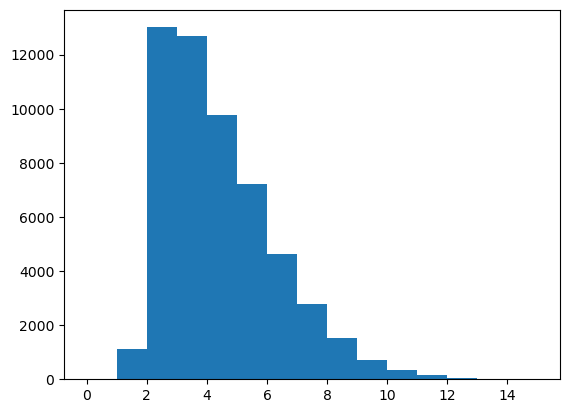

In [149]:
import matplotlib.pyplot as plt


plt.hist(dataset['num_mut'], bins=15, colors)
plt.show()

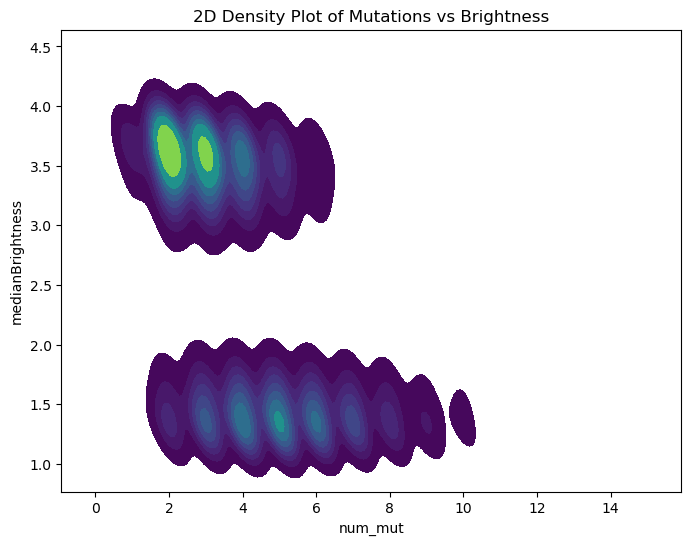

In [118]:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=dataset,
    x='num_mut',
    y='medianBrightness',
    fill=True,
    cmap="viridis",
    thresh=0.05
)
plt.title('2D Density Plot of Mutations vs Brightness')
plt.show()


### Check the region of the mutation

In [123]:
# extract region of mut
pattern = r'\D*(\d+)\D*'
def extract_region_mut(mut:str)->int:
    if type(mut)==str:
        mutations = mut.split(":")
        regions = [re.search(pattern=pattern, string=m).group(1) for m in mutations]
        return regions

dataset['mut_region'] = dataset['aaMutations'].apply(lambda mut: extract_region_mut(mut))

In [132]:
filtered = dataset[dataset['num_mut'] < 2].copy()

# Encode regions numerically (e.g., 'brain' -> 0, 'liver' -> 1, etc.)
filtered['mut_region'] = filtered['mut_region'][1:].apply(lambda m: m[0])
filtered['mut_region_encoded'] = filtered['mut_region'].astype('category').cat.codes

# Compute correlation
corr = filtered['mut_region_encoded'].corr(filtered['medianBrightness'], method='spearman')
print(f"Spearman correlation between region and brightness (mut < 2): {corr:.3f}")

Spearman correlation between region and brightness (mut < 2): -0.104


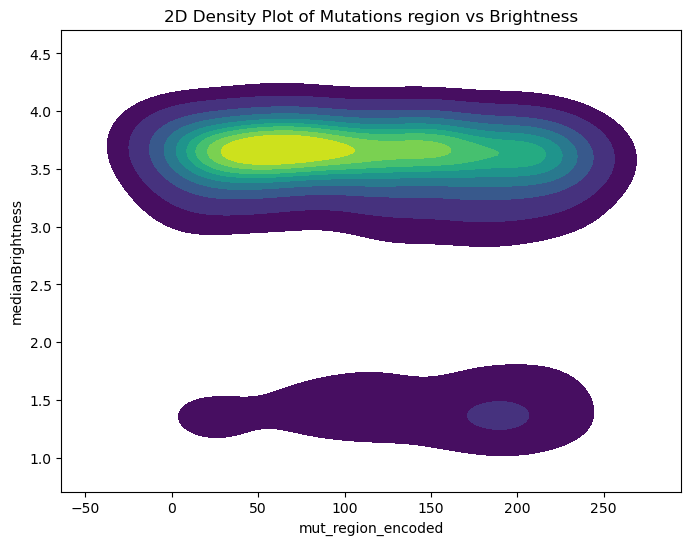

In [134]:
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=filtered,
    x='mut_region_encoded',
    y='medianBrightness',
    fill=True,
    cmap="viridis",
    thresh=0.05
)
plt.title('2D Density Plot of Mutations region vs Brightness')
plt.show()


### Type of mutation